In [1]:
# %pip install matplotlib
# %pip install pandas
#!pip3 install --upgrade pip
#!pip uninstall grpcio
#!pip3 install grpcio
#!pip install tensorflow-macos
#%pip install tensorflow-metal
# %pip install sklearn
#%pip install seaborn
# %pip install openpyxl

from __future__ import absolute_import, division, print_function
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import scatter_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import regularizers
from sklearn import tree
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, WhiteKernel, ConstantKernel as C
from sklearn.model_selection import GridSearchCV
import warnings

warnings.filterwarnings(action='once')

In [2]:
    # Dataset import
dataset_path = r'./dataset.xlsx'
raw_dataset = pd.read_excel(dataset_path, na_values="?", comment='\t')
dataset = raw_dataset.copy()
dataset=dataset.drop(columns=['Composition', 'Sintering Temperature','Sintering Pressure (Mpa)',
                              'Sintering Time (min)', 'Sintering Method', 'Oxidation Test', 'Time@Temp (min)','Atmospheric Prerssure',
                              'Oxygen Partial Pressure','Atmospheric Conditions','Flow Rate (cm3/min)' ])
#'Mean_Grain_Size' and 'Relative_Density'
dataset

,ZrC,TiB2,HfC,LaB6,MoSi2,TaSi2,SiC,ZrB2,TaC,Mean Grain Size (um),Relative Density (%),Temperature (C),Time@Temp (s),Oxide Thickness (um)
0,90,10,0,0,0,0,0,0,0,3.0,NaN,900.0,7200.0,NaN
1,80,20,0,0,0,0,0,0,0,7.0,NaN,900.0,7200.0,NaN
2,80,30,0,0,0,0,0,0,0,NaN,NaN,900.0,7200.0,NaN
3,100,0,0,0,0,0,0,0,0,2.0,97.4,1200.0,NaN,NaN
4,80,0,0,0,20,0,0,0,0,2.0,97.7,1200.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,0,0,50,0,0,0,0,0,50,NaN,99.2,1500.0,1800.0,180.0
75,0,0,75,0,0,0,0,0,25,NaN,96.5,1500.0,1800.0,130.0
76,0,0,80,0,0,0,0,0,20,NaN,95.9,1500.0,1800.0,250.0
77,0,0,0,40,0,0,60,0,0,3.0,80.4,2300.0,60.0,NaN


Oxide Thickness (um)    1.000000
MoSi2                   0.258750
Time@Temp (s)           0.228146
TaSi2                   0.126422
TaC                     0.076278
ZrC                     0.015568
ZrB2                   -0.016200
HfC                    -0.039621
SiC                    -0.055804
Mean Grain Size (um)   -0.212423
Temperature (C)        -0.326326
Relative Density (%)   -0.354873
TiB2                         NaN
LaB6                         NaN
Name: Oxide Thickness (um), dtype: float64


C:\Users\gbiancoa\AppData\Local\Temp\ipykernel_56356\4271815785.py:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


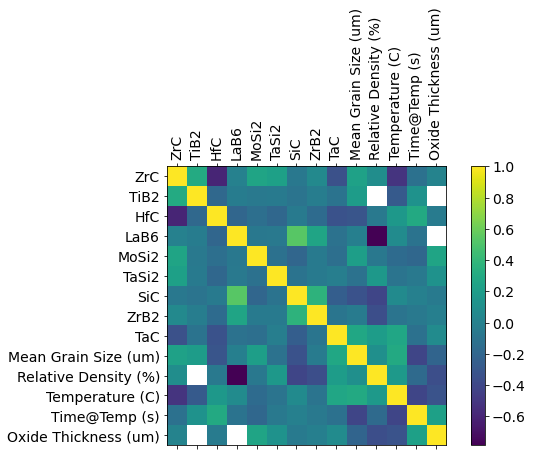

In [3]:
corr_matrix = dataset.corr()
print(corr_matrix["Oxide Thickness (um)"].sort_values(ascending=False))

f = plt.figure(figsize=(9, 5))
plt.matshow(dataset.corr(), fignum=f.number)
plt.xticks(range(dataset.select_dtypes(['number']).shape[1]), dataset.select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(dataset.select_dtypes(['number']).shape[1]), dataset.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
plt.tight_layout()

cb.ax.tick_params(labelsize=14)

In [ ]:
dataset = dataset.dropna(subset=['Oxide Thickness (um)'])
dataset.isna().sum()
plt.scatter(dataset['Temperature (C)'], dataset['Oxide Thickness (um)'])

In [ ]:
#Preprocessing
#split train-test
train_dataset = dataset.sample(frac=0.8, random_state=2)
test_dataset = dataset.drop(train_dataset.index)
test_dataset.head()

In [7]:
# In[4]: Separate Targets from features  Dataset
train_stats = train_dataset.describe()
train_stats.pop('Oxide Thickness (um)')
train_stats = train_stats.transpose()
train_labels = train_dataset.pop('Oxide Thickness (um)')
test_labels = test_dataset.pop('Oxide Thickness (um)')

In [8]:
# spacy - do their own embedding
# Word embedding - word2vec
# normalization - minmax

# In[5]: Normalization, This could change
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer

def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
imptrain = SimpleImputer(missing_values=np.nan, strategy='mean')
imptest = SimpleImputer(missing_values=np.nan, strategy='mean')

Train_scaler = MinMaxScaler()
Test_scaler = MinMaxScaler()

normed_train_data = Train_scaler.fit_transform(train_dataset)
normed_test_data = Test_scaler.fit_transform(test_dataset)

imptrain.fit(normed_train_data)
imptest.fit(normed_test_data)

normed_train_data = imptrain.transform(normed_train_data)
normed_test_data = imptest.transform(normed_test_data)
pd.DataFrame(normed_test_data).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.000000,0.0,0.66,0.0,0.0,0.0,1.000000,0.0,0.000000,0.000000,1.000000,1.0,0.013605
1,0.000000,0.0,0.66,0.0,0.0,0.0,1.000000,0.0,0.000000,0.000000,1.000000,1.0,0.047619
2,0.823529,0.0,0.00,0.0,0.0,0.0,0.882353,0.0,0.000000,0.280415,0.719298,0.0,0.081633
3,0.000000,0.0,1.00,0.0,0.0,0.0,0.000000,0.0,0.000000,1.000000,0.421053,1.0,0.000000
4,0.000000,0.0,0.80,0.0,0.0,0.0,0.000000,0.0,0.235294,0.905063,0.614035,1.0,0.000000


In [10]:
# Random Forest regressor with Gridsearch
param_grid = {
    "n_estimators": [7, 10,25,50,55,60,65,67,68],
    "criterion": ['mae','mse'],
    "max_features": [1.0],
    "max_depth": [None, 10, 15, 20, 25, 50],
    "min_samples_split": [2, 10, 15],
    "min_samples_leaf": [1, 2, 4, 15],
    'max_leaf_nodes' : [10,25,50,55,57,60,65,67, 80]
              }   
rfrreg_opt = GridSearchCV(RandomForestRegressor(), param_grid=param_grid, n_jobs=-1, cv=5)
rfr = rfrreg_opt.fit(normed_train_data, train_labels)
# rfr = RandomForestRegressor(n_estimators=500, max_depth=None, min_samples_split=2, min_samples_leaf=2, max_leaf_nodes=None,bootstrap=True, oob_score=False, n_jobs=1, random_state=2)
# rfr = rfr.fit(normed_train_data, train_labels) 

#Linear Models
Lin = linear_model.Ridge(alpha=.6) # Ridge
# Lin = linear_model.Lasso(alpha=0.001) # Lasso Linear Mode
Lin = Lin.fit(normed_train_data, train_labels)
# Lin = linear_model.LinearRegression() # Ordinary Least6 Squares

#Gaussian Process regressor
# define a prior i.e. a distribution of functions
# what this really means: choose a kernel and kernel hyperparameters
# kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-5, 10.0)) + 1.0 * WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-5, 10.0))
kernel = 1 * RationalQuadratic(length_scale=0.01, alpha=0.05)
gp = GaussianProcessRegressor(kernel=kernel,alpha=0.1,optimizer='fmin_l_bfgs_b')
gp.fit(normed_train_data, train_labels)
# Cross validation
    

C:\Users\gbiancoa\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\gbiancoa\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\gbiancoa\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value 

GaussianProcessRegressor(alpha=0.1,
                         kernel=1**2 * RationalQuadratic(alpha=0.05, length_scale=0.01))

In [ ]:
# Testing
test_dataset["label"] = test_labels
#predictions is tets set
rfr_predict = rfr.predict(normed_test_data).flatten()
lin_predict = Lin.predict(normed_test_data).flatten()
GPR_predict = gp.predict(normed_test_data).flatten()
test_dataset["RFR predictions"] = rfr_predict
test_dataset["Lin predictions"] = lin_predict
test_dataset["GPros predictions"] = GPR_predict
avg = np.add(rfr_predict,np.add(lin_predict, GPR_predict))/3
test_dataset.to_csv("test_dataset_pred.csv")


plt.figure(dpi=200)
plt.scatter(test_labels, rfr_predict, c='orange',s=20, marker='*',zorder=2, label="Testing Set")
plt.scatter(train_labels, train_labels, c='green',s=5, marker='o',zorder=1, label="Train Set")
plt.legend()
plt.title("Random Forest Regressor")
plt.xlabel(r'True Values [Oxide Thickness ($\mu$m)]')
plt.ylabel(r'Predictions [Oxide Thickness ($\mu$m)]')
plt.axis('equal')
plt.axis('square')
plt.xlim([-10,850])
plt.ylim(-10,850)
_ = plt.plot([-1000, 1000], [-1000, 1000],zorder=1, alpha = 0.7)
plt.savefig('rfrpred')
plt.show()
MAE = {'RFR': [mean_absolute_error(test_labels,rfr_predict)],
     'Lin': [mean_absolute_error(test_labels,lin_predict)],
      'GPros': [mean_absolute_error(test_labels,GPR_predict)],
      "Ensemmble": [mean_absolute_error(test_labels,avg)]}
MAE = pd.DataFrame(data=MAE)
print('Mean absulote error: ', mean_absolute_error(test_labels,rfr_predict))
R2 = {'RFR': [r2_score(test_labels,rfr_predict)],
     'Lin': [r2_score(test_labels,lin_predict)],
      'GPros': [r2_score(test_labels,GPR_predict)],
      "Ensemmble": [r2_score(test_labels,avg)]}
R2 = pd.DataFrame(data=R2)
print(f'Coefficient of Determination: {r2_score(test_labels,rfr_predict)}')
print('Parameters:', rfr.best_params_)

<Figure size 432x288 with 0 Axes>

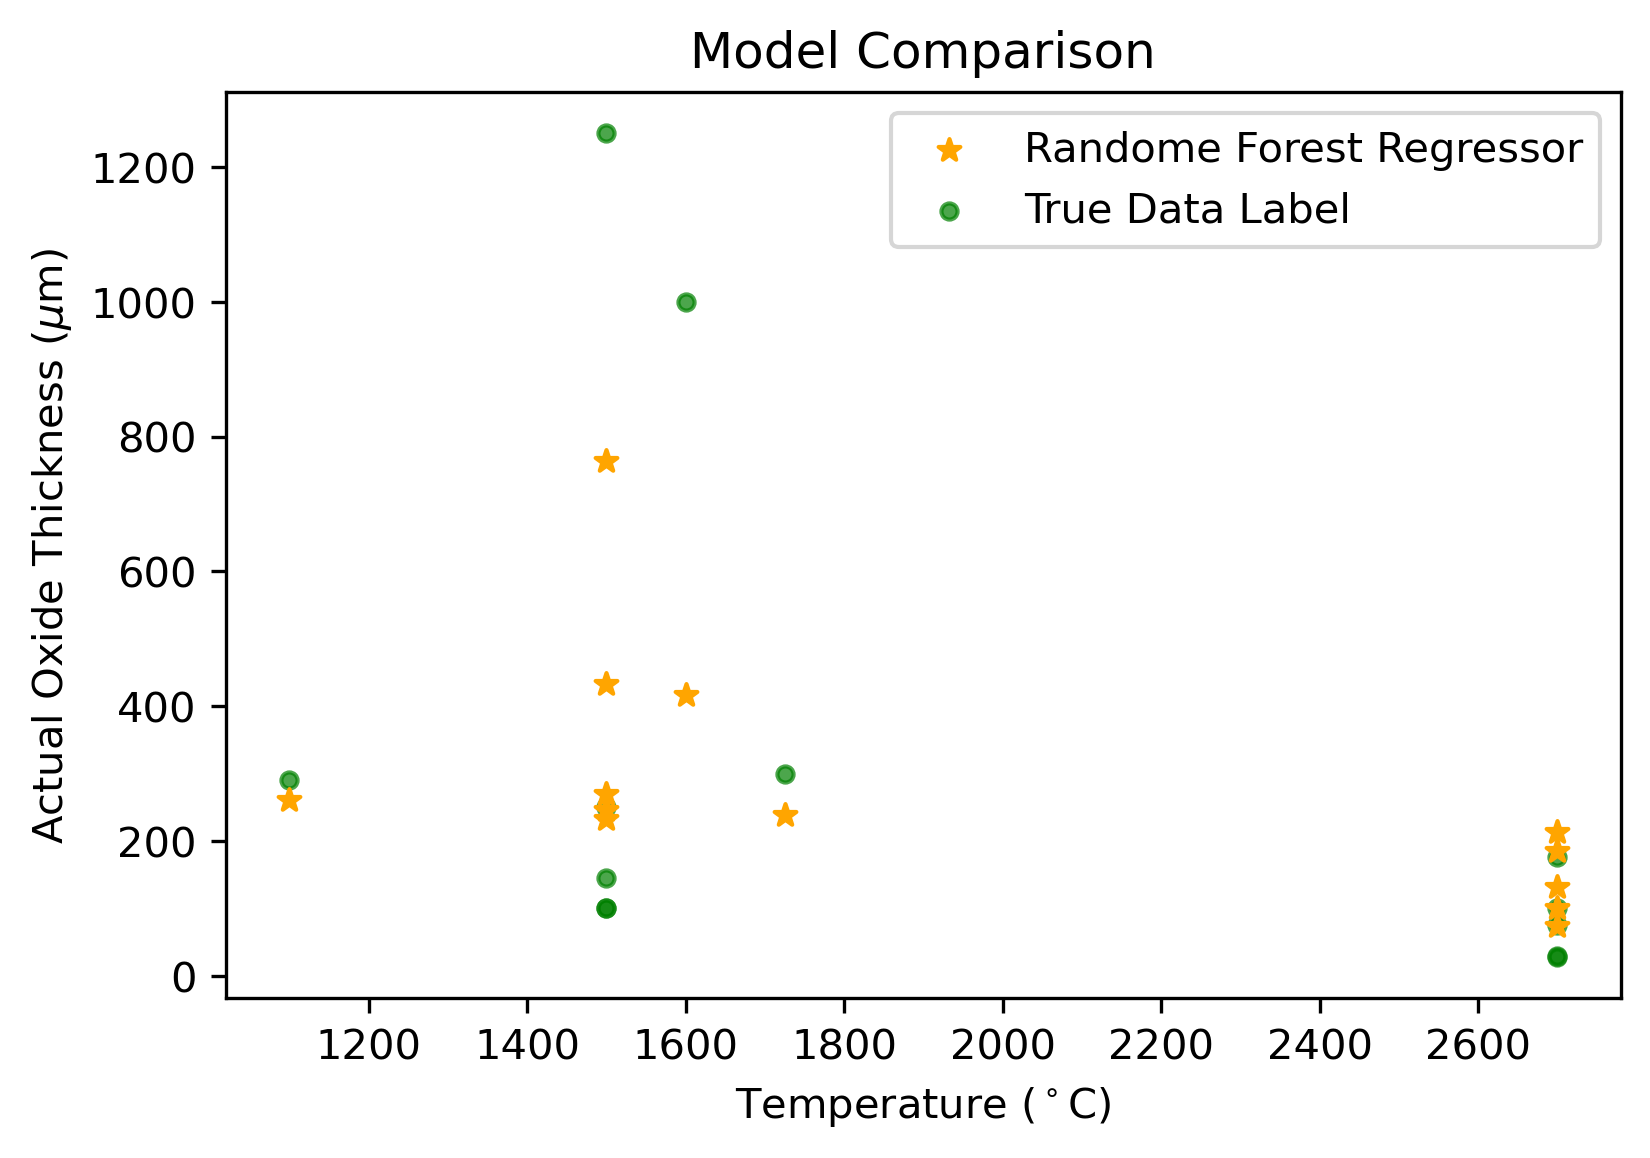

In [14]:
d = {'True values': test_labels, 'Pred1': rfr_predict, 'temperature': test_dataset["Temperature (C)"]}
pdp = pd.DataFrame(data=d)
pdp = pdp.sort_values(by=['temperature'], ascending=False)

fig = plt.figure()
plt.figure(dpi=300)
plt.scatter(pdp['temperature'],pdp['Pred1'], c='orange',label='Randome Forest Regressor',s=30,marker="*", zorder=3)
#plt.plot(pdp['temperature'],pdp['True values'], c='g', label='True Data Line',linewidth=1, zorder=1, alpha=0.5 )
plt.scatter(pdp['temperature'],pdp['True values'], c='g', label='True Data Label',s=15, zorder=2, alpha=0.7 )
plt.title('Model Comparison')
plt.ylabel(r'Actual Oxide Thickness ($\mu$m)')
plt.xlabel(r'Temperature ($^\circ$C)')
plt.legend()
plt.savefig('Comparepred')
plt.show()